# Digit recognition - multiclass classification


## Processing of collected data (not MNIST)

In [67]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, BatchNormalization, Conv1D
from keras.optimizers import RMSprop, SGD, Adam
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

In [16]:
df = pd.read_csv("data/drawings.csv")

In [63]:
model = Sequential([
        Conv2D(32,(3,3), padding="same", activation='relu', input_shape=(28,28,1)),
        BatchNormalization(axis=1),
        Conv2D(32,(3,3), activation='relu'),
        MaxPool2D(),
        BatchNormalization(axis=1),
        Conv2D(64,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        Conv2D(64,(3,3), activation='relu'),
        MaxPool2D(),
        Flatten(),
        Dropout(0.25),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(10, activation='softmax')
        ])

model.compile(Adam(), "categorical_crossentropy")

In [64]:
y = to_categorical(df.label)
hist = model.fit(np.array(df.iloc[:, :-1]).reshape(len(df), 28, 28, 1), y, epochs=3, batch_size=10, validation_split=0.2, shuffle=True)

Epoch 1/3
442/442 [==============================] - 17s 38ms/step - loss: 0.3969 - val_loss: 1.0274
Epoch 2/3
442/442 [==============================] - 17s 39ms/step - loss: 0.1207 - val_loss: 0.1102
Epoch 3/3
442/442 [==============================] - 18s 41ms/step - loss: 0.0856 - val_loss: 0.0552


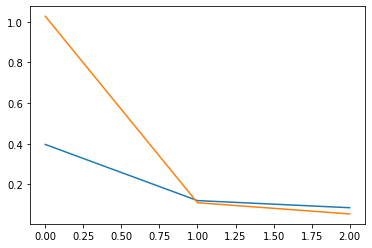

In [65]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"]);

In [83]:
model2 = Sequential([
        Conv2D(32,(3,3), padding="same", activation='relu', input_shape=(28,28,1)),
        BatchNormalization(axis=1),
        Conv2D(32,(3,3), activation='relu'),
        MaxPool2D(),
        BatchNormalization(axis=1),
        Conv2D(64,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        Conv2D(64,(3,3), activation='relu'),
        MaxPool2D(),
        Flatten(),
        Dropout(0.25),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(24, activation='sigmoid'),
        BatchNormalization(axis=1),
        Dense(10, activation="softmax")
        ])

model2.compile(Adam(), "categorical_crossentropy")

In [84]:
hist2 = model2.fit(np.array(df.iloc[:, :-1]).reshape(len(df), 28, 28, 1), y, epochs=3, batch_size=10, validation_split=0.2, shuffle=True)

Epoch 1/3
442/442 [==============================] - 19s 41ms/step - loss: 0.4757 - val_loss: 1.1106
Epoch 2/3
442/442 [==============================] - 18s 41ms/step - loss: 0.1635 - val_loss: 0.1903
Epoch 3/3
442/442 [==============================] - 19s 43ms/step - loss: 0.1144 - val_loss: 0.0445


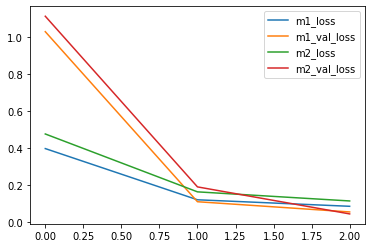

In [86]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.plot(hist2.history["loss"])
plt.plot(hist2.history["val_loss"]);
plt.legend(["m1_loss", "m1_val_loss", "m2_loss", "m2_val_loss"])